## Lipid maps pulldown prep

"LIPID Metabolites And Pathways Strategy (LIPID MAPS) is a multi-institutional supported website and database that provides access to a large number of globally used lipidomics resources." (["About us" page](https://www.lipidmaps.org/about/information))

The [LIPID MAPS Structure Database (LMSD)](https://www.lipidmaps.org/databases/lmsd/download) provides chemical formula in SMILES format of over 50,000 lipids.

A/B hydrolase protein 2090 may act on lipids. What if we were to use AlphaFold 3 to give us a clue as to which type of lipids this enzyme may be acting on?

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from scipy.stats import entropy

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()

base_folder = Path(os.path.expanduser('~')) / 'Documents' / 'Chahrazad'
assert base_folder.is_dir()

## Load Lipid Maps Structure Database (LMSD)

In [3]:
lmsd_path = (base_folder / 'lipid_maps' / 'lipids.sdf').resolve().as_posix()
lipids = Chem.SDMolSupplier(lmsd_path)

In [4]:
for lipid in lipids:
    break

print('Available attributes:')
attributes = list(lipid.GetPropNames())
attributes

Available attributes:


['LM_ID',
 'NAME',
 'SYSTEMATIC_NAME',
 'CATEGORY',
 'MAIN_CLASS',
 'EXACT_MASS',
 'FORMULA',
 'INCHI_KEY',
 'INCHI',
 'SMILES',
 'ABBREVIATION',
 'SYNONYMS',
 'PUBCHEM_CID',
 'CHEBI_ID']

In [5]:
for attribute in lipid.GetPropNames():
    print(f'{attribute}:', lipid.GetProp(attribute))

LM_ID: LMFA00000001
NAME: 2-methoxy-12-methyloctadec-17-en-5-ynoyl anhydride
SYSTEMATIC_NAME: 2-methoxy-12-methyloctadec-17-en-5-ynoyl anhydride
CATEGORY: Fatty Acyls [FA]
MAIN_CLASS: Other Fatty Acyls [FA00]
EXACT_MASS: 626.491025
FORMULA: C40H66O5
INCHI_KEY: VOGBKCAANIAXCI-UHFFFAOYSA-N
INCHI: InChI=1S/C40H66O5/c1-7-9-11-23-29-35(3)31-25-19-15-13-17-21-27-33-37(43-5)39(41)45-40(42)38(44-6)34-28-22-18-14-16-20-26-32-36(4)30-24-12-10-8-2/h7-8,35-38H,1-2,9-16,19-20,23-34H2,3-6H3
SMILES: C(C(OC)CCC#CCCCCCC(C)CCCCC=C)(=O)OC(C(OC)CCC#CCCCCCC(C)CCCCC=C)=O
ABBREVIATION: FA 40:7;O3
SYNONYMS: Acetylenic acids
PUBCHEM_CID: 10930192
CHEBI_ID: 178363


In [6]:
mass_list = []
molecules = []
for lipid in lipids:
    if lipid and 'SMILES' in lipid.GetPropNames():
        lm_id = lipid.GetProp('LM_ID')
        mass = float(lipid.GetProp('EXACT_MASS'))

        assert not pd.isnull(mass) and mass > 0

        mass_list.append((lm_id, mass))
        molecules.append(lipid)

print(f'Number of lipids in LMSD: {len(mass_list):,}')

[11:41:37] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[11:41:37] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[11:41:37] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[11:41:37] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[11:41:37] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 5 ignored
[11:41:37] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 7 ignored.
[11:41:37] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 7 ignored.
[11:41:37] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 7 ignored.
[11:41:37] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 7 ignored.
[11:41:37] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 3 ignored.
[11:4

Number of lipids in LMSD: 48,233


[11:41:40] Warning: conflicting stereochemistry - bond wedging contradiction - at atom 56 ignored
[11:41:40] Warning: conflicting stereochemistry - bond wedging contradiction - at atom 56 ignored


### Export as csv

In [7]:
def export_lipids_as_table(molecules):
    columns = [
        'LM_ID',
        'NAME',
        'CATEGORY',
        'MAIN_CLASS',
        'SUB_CLASS',
        'EXACT_MASS',
        'FORMULA',
        'SMILES',
        'PUBCHEM_CID',
    ]
    data = {c: [] for c in columns}
    for molecule in molecules:
        available_attributes = set(molecule.GetPropNames())
        for attr in columns:
            if attr in available_attributes:
                val = molecule.GetProp(attr)
            else:
                val = None

            data[attr].append(val)

    return pd.DataFrame.from_dict(data).set_index('LM_ID', drop=True)

In [8]:
lipids_df = export_lipids_as_table(molecules)
lipids_df.head()

,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,SMILES,PUBCHEM_CID
LM_ID,,,,,,,,
LMFA00000001,2-methoxy-12-methyloctadec-17-en-5-ynoyl anhyd...,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,626.491025,C40H66O5,C(C(OC)CCC#CCCCCCC(C)CCCCC=C)(=O)OC(C(OC)CCC#C...,10930192
LMFA00000002,Serratamic acid,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,275.173274,C13H25NO5,C(O)[C@](C(=O)O)([H])NC(C[C@@H](O)CCCCCCC)=O,42607281
LMFA00000003,N-(3-(hexadecanoyloxy)-heptadecanoyl)-L-ornithine,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,638.559773,C38H74N2O5,C(CCN)[C@](C(=O)O)([H])NC(CC(OC(CCCCCCCCCCCCCC...,42607282
LMFA00000005,N-(3-(15-methyl-hexadecanoyloxy)-13-methyl-tet...,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,625.528139,C37H71NO6,CC(C)CCCCCCCCCCCC(OC(=O)CCCCCCCCCCCCCC(C)C)CC(...,42607283
LMFA00000006,Lysine-containing siolipin,Fatty Acyls [FA],Other Fatty Acyls [FA00],None,684.565253,C39H76N2O7,N([C@@]([H])(CCCCN)C(=O)OCCOC(=O)C(O)CCCCCCCCC...,42607284


In [9]:
lipids_df.to_csv(base_folder / 'lipid_maps' / 'lipids.csv')

## Sample 100 lipids

We'll start by running AF3 on a subset of 100 lipids. This should help estimate runtime on the full 50k DB.

We want the distribution of molecular weights in the sample to be as close as possible to the full distribution. We'll generate 100 independent samples, compute the KL divergence vs the entire distribution and keep the sample with the smallest KL divergence.

In [10]:
n_samples = 100
n_generations = 100
n_bins = 20
seed = 123
rng = np.random.default_rng(seed)

all_masses = np.array([m for _, m in mass_list], dtype=np.float32)
bin_counts, _ = np.histogram(all_masses, bins=n_bins, density=False)
full_distribution = bin_counts / np.sum(bin_counts)

samples = []
for _ in range(n_generations):
    s = rng.choice(mass_list, size=n_samples, replace=False)
    sample_masses = np.array([m for _, m in s], dtype=np.float32)
    s_bin_counts, _ = np.histogram(sample_masses, bins=n_bins, density=False)
    sample_distribution = s_bin_counts / np.sum(s_bin_counts)

    kl_divergence = entropy(full_distribution, sample_distribution)

    samples.append((s, kl_divergence))

sample_tuples = sorted(samples, key=lambda t: t[1])
print(f'Best KL divergence  : {sample_tuples[0][1]}')
print(f'Worst KL divergence : {sample_tuples[-1][1]}')

sample = sample_tuples[0][0]

Best KL divergence  : 0.4250911413508963
Worst KL divergence : inf


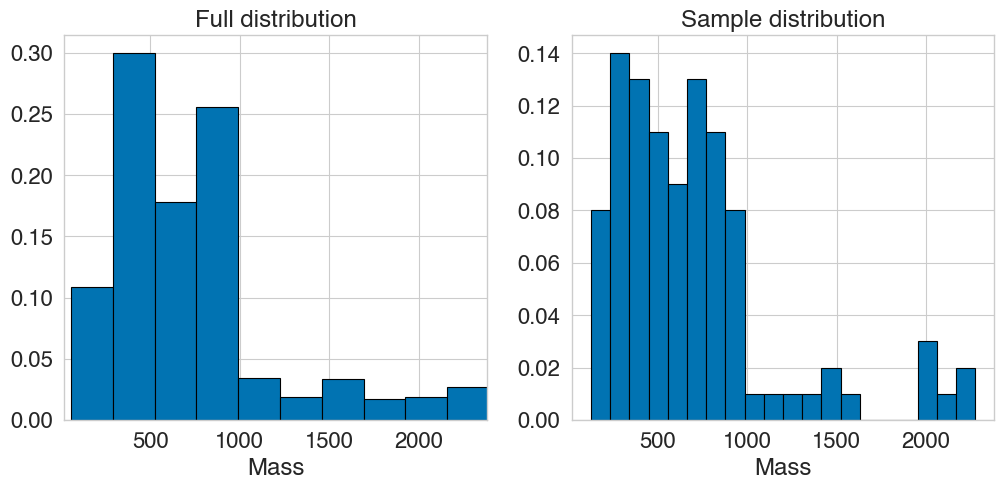

In [11]:
f, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = axes.flatten()

sample_masses = np.array([m for _, m in sample], dtype=np.float32)

for ax, data in [(ax1, all_masses), (ax2, sample_masses)]:
    bin_counts, bin_edges = np.histogram(data, bins=n_bins, density=False)
    bin_probabilities = bin_counts / np.sum(bin_counts)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.bar(bin_centers, bin_probabilities, width=np.diff(bin_edges), edgecolor='black', align='center')

ax1.set_xlim(ax2.get_xlim());

ax1.set_title('Full distribution');
ax2.set_title('Sample distribution');

ax1.set_xlabel('Mass');
ax2.set_xlabel('Mass');

### Export subset

In [12]:
sample_ids = {lm_id for lm_id, _ in sample}
samples_df = lipids_df.loc[sorted(sample_ids)]
samples_df.head()

,NAME,CATEGORY,MAIN_CLASS,SUB_CLASS,EXACT_MASS,FORMULA,SMILES,PUBCHEM_CID
LM_ID,,,,,,,,
LMFA01020032,(+)-C27-Phthienoic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Branched fatty acids [FA0102],408.396730,C27H52O2,C(CCCCCCCC(C)CC(C)/C=C(\C)/C(=O)O)CCCCCCCCCC,5282613
LMFA01030109,"9,12-hexadecadienoic acid",Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Unsaturated fatty acids [FA0103],252.208930,C16H28O2,C(/C/C=C/CCC)=C\CCCCCCCC(=O)O,5282787
LMFA01030372,8Z-eicosenoic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Unsaturated fatty acids [FA0103],310.287180,C20H38O2,C(CCCCCC/C=C\CCCCCCCCCCC)(=O)O,5312523
LMFA01050220,28-hydroxy-octacosanoic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Hydroxy fatty acids [FA0105],440.422945,C28H56O3,C(CCCCCCCCCCCCCCCCCCCCCCCCCCCO)(=O)O,5312786
LMFA01050225,6-hydroxy-heptanoic acid,Fatty Acyls [FA],Fatty Acids and Conjugates [FA01],Hydroxy fatty acids [FA0105],146.094295,C7H14O3,C(CCCCC(O)C)(=O)O,5312788


In [13]:
samples_df.to_csv(base_folder / 'lipid_maps' / 'lipids_sample.csv')